In [1]:
from read_data import read_data

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [2]:
train_df, test_df, test_labels_df = read_data("data/")

# ignore test values with -1 labels
test_df_usable = test_df.loc[test_labels_df['toxic'] != -1]
test_labels_df_usable = test_labels_df.loc[test_labels_df['toxic'] != -1]

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [3]:
# establish train and test datasets
train_X = train_df['comment_text']
train_y = train_df[label_cols]
test_X = test_df_usable['comment_text']
test_y = test_labels_df_usable[label_cols]

In [4]:
# # shrink dataset for quicker train/test iterations
# train_X = train_X.iloc[:1200]
# train_y = train_y.iloc[:1200]
# test_X = test_X.iloc[:300]
# test_y = test_y.iloc[:300]

Chain order: insult, obscene, toxic, severe_toxic, identity_hate, threat  
(idx: 4, 2, 0, 1, 5, 3)

In [5]:
tf_idf = TfidfVectorizer(ngram_range=(1,1), lowercase=True, stop_words="english")
train_X_tf = tf_idf.fit_transform(train_X)
test_X_tf = tf_idf.transform(test_X)
print(train_X_tf.shape, test_X_tf.shape)

(159571, 189460) (63978, 189460)


In [6]:
order = [4, 2, 0, 1, 5, 3]

base = LogisticRegression(class_weight="balanced", C=5)
# base = XGBClassifier(n_estimators=100, learning_rate=0.33, scale_pos_weight=20)
chain = ClassifierChain(estimator=base, order=order, chain_method="predict_proba", random_state=42)
print(chain.get_params(deep=True))

chain.fit(train_X_tf, train_y)

pred = chain.predict(test_X_tf)
pred_proba = chain.predict_proba(test_X_tf)

print(f"Accuracy: {round(chain.score(test_X_tf, test_y), 4)}")

{'base_estimator': 'deprecated', 'chain_method': 'predict_proba', 'cv': None, 'estimator__C': 5, 'estimator__class_weight': 'balanced', 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'deprecated', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=5, class_weight='balanced'), 'order': [4, 2, 0, 1, 5, 3], 'random_state': 42, 'verbose': False}
Accuracy: 0.8047


In [7]:
print(classification_report(y_true=test_y, y_pred=pred, target_names=[label_cols[idx] for idx in order], zero_division=0))

               precision    recall  f1-score   support

       insult       0.43      0.92      0.59      6090
      obscene       0.11      0.88      0.20       367
        toxic       0.43      0.90      0.58      3691
 severe_toxic       0.16      0.85      0.27       211
identity_hate       0.41      0.84      0.55      3427
       threat       0.19      0.86      0.31       712

    micro avg       0.37      0.89      0.52     14498
    macro avg       0.29      0.88      0.42     14498
 weighted avg       0.40      0.89      0.55     14498
  samples avg       0.06      0.09      0.07     14498



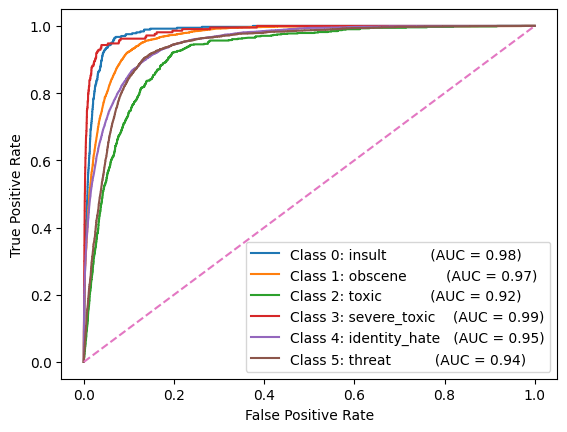

In [19]:
y_true_bin = label_binarize(test_y, classes=[label_cols[idx] for idx in order])

# Compute ROC curve and AUC for each class
for i in range(y_true_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred_proba[:, i])
    roc_auc = roc_auc_score(y_true_bin[:, i], pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}: {label_cols[order[i]].ljust(15)} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()